## Transformata Hough'a dla znajdowania okręgów na obrazach RGB.

Imię, nazwisko: Krzysztof Jarek.

Grupa: nr 1.

Data oddania: 7.12.2021.


---

##Cele:
*   implementacja funkcji dokonującej dobrej binaryzacji dla celów znajdowania okręgów,
*   implementacja transformaty Hough'a dla celu znajdowania okręgów.




##Przebieg:

Wykorzystane oprogramowanie: Google Colaboratory



Podjęty problemem polega na tym by można było rozpoznawać kształty okręgów na obrazach. W tym celu w ramach projektu uwaga została zwrócona na transformatę Hough'a- czy też pewne rozwiązanie korzystające z niej- dedykowaną dla przypadku rozpoznawania kształtów kolistych.

Zanim jednak przystąpi się do implementacji samej transformaty, najpierw należy zbudować konieczne narzędzie do odpowiedniej obróbki zdjęć tak by mogły się nadawać do dalszej, właściwej analizy.

In [1]:
import math
import numpy as np
from PIL import Image, ImageDraw
import cv2
from skimage.morphology import skeletonize
from collections import defaultdict
from matplotlib import pyplot as plt

W ramach realizacji projektu zostały wykorzystane warte wspomnienia moduły *python*'a:

*   *numpy* - pakiet dla realizacji operacji algebry liniowej, napisany w *C*,
*   *PIL* - moduł dla podstawowych operacji na zdjęciach,
*   *cv2*, *skimage* - moduły zawierające zaawandowane funkcje wykorzystywane podczas obróbki obrazu,
*   *matplolib* - pakiet dla wizualizacji wykresów i nie tylko.

Jako testowy, będzie wykorzystywany obrazek przedstawiający szesnaście piłeczek, widoczny poniżej:

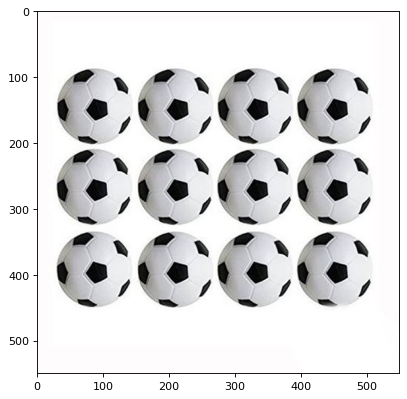

In [2]:
img = Image.open('foosball-balls.jpeg')

plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(np.uint8(img))

Testowa fotografia następnie została poddana szeregowi przetworzeń, mających na celu dobre odseparowanie krawędzi obiektów obecnych na nim. Główną operacją jakiej ją poddano, dla wydobycia brzegów, była *metoda Cannego*. Nie mniej analizując po kolei, należy wymienić następujące po sobie operacje:

*   dokonanie rozmazania gaussowskiego z wykorzystaniem jądra 3x3,
*   detekacja brzegów *Cannego*,
*   binaryzacja z progiem wynoszącym 127 (wartości w macierzy wynoszące 0 lub 255),
*   szkieletyzacja.

Sam ciąg operacji został zaimplementowany dalej w funkcji *canny_edge_detection()* - natomiast funkcja ta zwraca listę punktów jakie pozostają w efekcie niego wygenerowane dzięki operacji *np.column_stack()*- z tego też powodu nie można było prosto zaprezentować tego z użyciem samej funkcji.

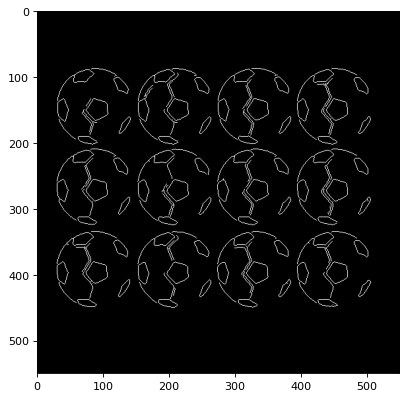

In [3]:
img_for_canny = np.uint8(img.convert('L'))

blurred = cv2.GaussianBlur(img_for_canny, (3, 3), 0)
img_canny = cv2.Canny(blurred, 40, 215)

img_canny_bin = np.where(img_canny > 127, 1, 0)
img_skel = skeletonize(img_canny_bin)


plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(img_skel, cmap='gray')

In [4]:
def canny_edge_detection(img):
    lower = 40; upper = 215
    threshold = 127
    
    gray_scale = np.uint8(img.convert('L'))
    
    blurred = cv2.GaussianBlur(gray_scale, (3, 3), 0)
    img_canny = cv2.Canny(blurred, lower, upper)
    
    img_canny_bin = np.where(img_canny > threshold, 1, 0)
    img_skel = np.uint8(skeletonize(img_canny_bin) * 255)
    
    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(img_skel, cmap='gray')
    plt.show()
    
    points_list = np.column_stack(np.where(img_skel > threshold))
    
    return points_list

Dalej, przechodząc do samej implementacji rozwiązania korzystającego z koncepcji transforamty Hough'a, napisano kolejne fukcje. Nie mniej pierw należałoby przedstawić sam koncept transformaty wykorzystującej tu parametryczne równanie okręgu prezentujace się następująco:

\begin{matrix}
 x = a + Rcos(\theta)\\y = b + Rsin(\theta)
\end{matrix}

Aby móc wygenerować odpowiednie zbiory trójek: promień (***R***), ***R***cos(θ), ***R***sin(θ), idąc za powyższym konceptem, została utworzona funkcja *add_points()* mająca za zadanie przygotowywanie ich:

In [5]:
def add_points(R_min, R_max, steps):
    points = []
    
    for r in range(R_min, R_max+1):
        for t in range(steps):
            points.append((r, int(r * math.cos(2*math.pi*t/steps)), int(r * math.sin(2*math.pi*t/steps))))
    
    return points

Następnie utworzona została funkcja *make_canny_detedtion()* mająca za zadanie wykorzystać znalezione przez *canny_edge_detedtion()* punkty, *pixels_cords*, i dostarczone wcześniej wspomniane trójki dla celu dokonania akumulacji. Zdefioniowano w niej obiekt akumulatora *acc* typu *defaultdict(int)*, w jakim to akumulowane będą zliczenia punktów reprezentujących przestrzeń uzyskaną dzięki transformacie dla poszczególnych potencjalnych okręgów, a sam proces będzie się odbywał wewnątrz podwójnej pętli. Oparte to będzie o zależność:

\begin{matrix}
 a = x_{0} - Rcos(\theta)\\b = y_{0} - Rsin(\theta)
\end{matrix}

Co można tu przyznać to tak określone podejście może jednak mieć charakter *brute force*. Mimo tego, że dość transparentnie prezentuje sam problem, niekoniecznie jest najbardziej sprytne, efektywne.

In [6]:
def make_canny_detedtion(img, points):
    acc = defaultdict(int)
    
    pixels_cords = canny_edge_detection(img)
    
    for i, j in pixels_cords:
        for r, di, dj in points:
            a = i - di
            b = j - dj
            acc[(a, b, r)] += 1
    
    return acc

Funkcja *get_circles()* została stworzona dla wykorzystania wcześniej stworzonego akumulatora *acc* zawierającego punkty reprezentujące domenę uzyskaną po transformacie w celu zbudowania listy okręgów znajdujących się na pierwotnym obrazie (okrąg: środek znajdujący się na fotografii wraz z promieniem), uwzględniając zadany próg *threshold* służący limitowania minimalnej ilości wystąpień pikseli jakie mogą wchodzić w skład potencjalnego koła (np. stwierdzamy istnienie okręgu, bo występuje 50% jego potencjalnej długości).

In [7]:
def get_circles(acc, threshold, steps):
    circles = []
    
    for k, v in sorted(acc.items(), key=lambda i: -i[1]):
        x, y, r = k
        if v / steps >= threshold and all((x - xc)**2 + (y - yc)**2 > rc**2 for xc, yc, rc in circles):
            circles.append((x, y, r))
            
    return circles

Funkcja *add_circles()* w skrócie ma za zadanie umieścić na pierwotnej fotografii, narysowane na czerwono, znalezione okręgi, i zwrócić tak uzyskany nowy obraz:

In [8]:
def add_circles(img, circles):
    new_img = Image.new("RGB", img.size)
    new_img.paste(img)
    drowing_on_img = ImageDraw.Draw(new_img)
        
    for i, j, r in circles:
        drowing_on_img.ellipse((j-r, i-r, j+r, i+r), outline=(255,0,0,0))
    
    return new_img

Ostatecznie, zbierając wszystko do kupy, cały proces został zawarty w specjalnie do tego przygotowanej funkcji o nazwie *hough_transform()* w ten sposób, że wszystkie wcześniej stworzone operacje zostają jedna po drugiej wywoływane, przekazując sobie odpowiednio dane. Interface funkcji przyjmuje trzy obiekty: sam obraz *img*, najmniejszy i największy dopuszczalny promień *R_min* i *R_max*.

In [9]:
def hough_transform(img, R_min, R_max):
    steps = 100
    threshold_lvl = 0.25
    
    points = add_points(R_min, R_max, steps)
    
    acc = make_canny_detedtion(img, points)
    
    circles = get_circles(acc, threshold_lvl, steps)
    
    new_img = add_circles(img, circles)
    
    return new_img

Wstępny test został przeprowadzony na wybranym do tego wcześniej obrazie *foosball-balls.jpeg*- efekt:

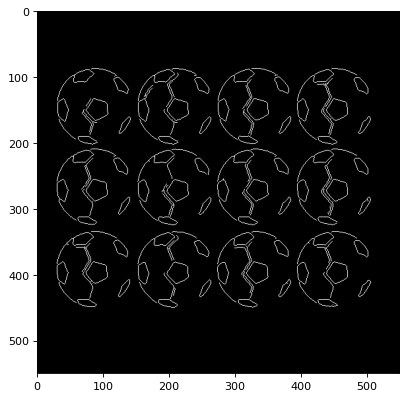

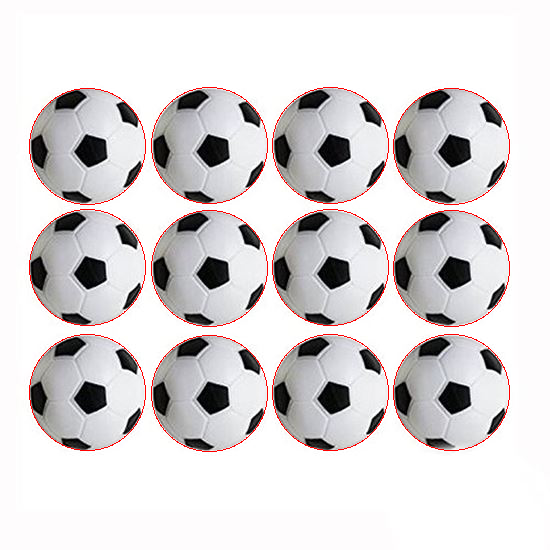

In [10]:
img_balls = Image.open('foosball-balls.jpeg')

new_img_balls = hough_transform(img_balls, int(min(img_balls.size)/10), int(min(img_balls.size)/4))

new_img_balls

Proces przebiega pomyślnie. Transformata, w takim razie, zostanie zastosowana w ramach projektu jeszcze raz, tym razem na nieco bardziej skomplikowanych przypadkach:

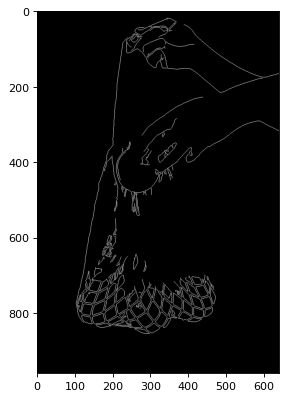

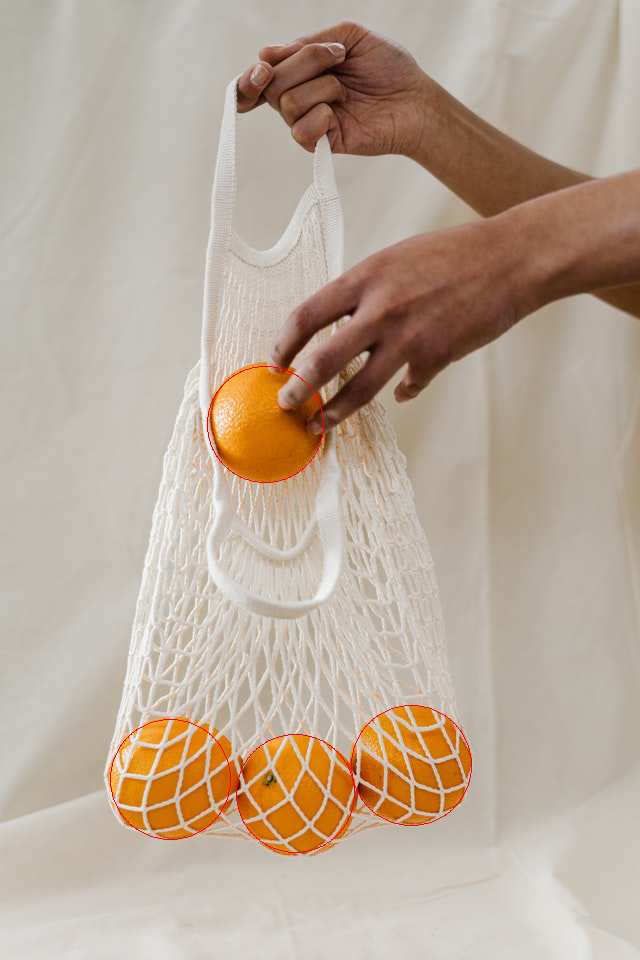

In [11]:
img_oranges = Image.open('oranges_bag.jpg')

new_img_oranges = hough_transform(img_oranges, int(min(img_oranges.size)/11), int(min(img_oranges.size)/10.5))

new_img_oranges

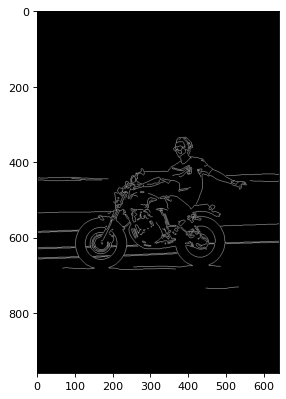

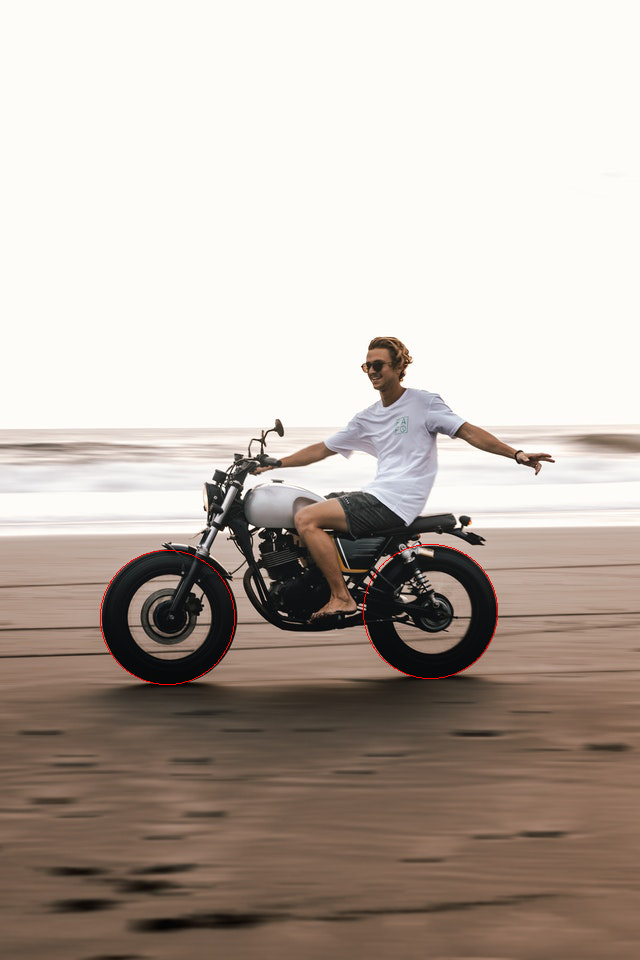

In [12]:
img_motorbike = Image.open('motorbike.jpg')

new_img_motorbike = hough_transform(img_motorbike, int(min(img_motorbike.size)/10), int(min(img_motorbike.size)/9.5))

new_img_motorbike

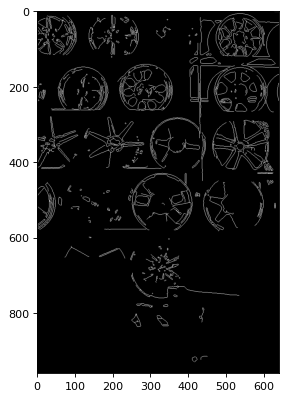

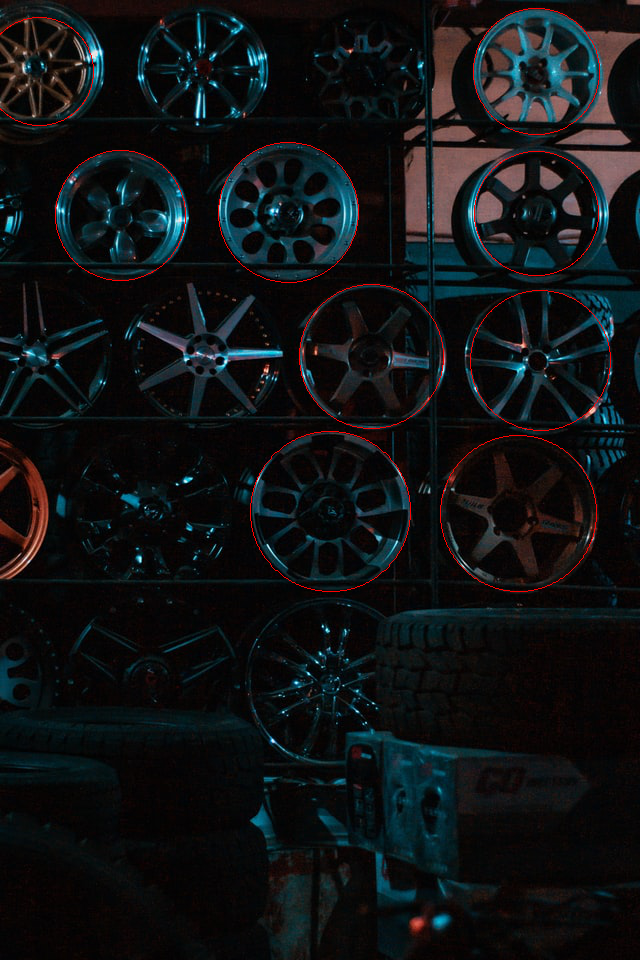

In [13]:
img_wheels = Image.open('wheels.jpg')

new_img_wheels = hough_transform(img_wheels, int(min(img_wheels.size)/12), int(min(img_wheels.size)/8))

new_img_wheels

Jak można zauważyć to nie zawsze detekcja okręgów wypadała w pełni zadowalająco- nie mniej co jeszcze jaśniej się uwidoczniło to kwestia zależności jej od jakości dostarczonego obrazu binarnego. Nie mniej jest to częsty problem obecny podobnie i w typowych pracach badawczych [1].

##Podsumowanie:

*   Ważnym jest odpowiednie przygotowanie obrazów pod dalsze procesy, tak jak tu pod transformatę Hough'a zostały one przygotowane.
*   Detekcja brzegów Canny'ego jest świetnym rozwiązaniem dla problemu znajdowania krawędzi obiektów na fotografiach- operacja szkieletyzacji bardzo dobrze wzmacnia koncowy efekt.
*   Transformata Hough'a świtnie się nadaje do znajdowania okręgów na obrazkach, nawet jesli obiekty o takich kształtach nie są w pełni widoczne. Koncepcja akumulatora jest bardzo ciekawą- nawet z samej racji jako koncepcja programistyczna.
*   Przyjęte rozwiązanie, lubiane być proponowanym, niekoniecznie najlepiej się sprawdza z racji na duże obciążenie obliczeniowe, a zwłaszcza na pamięci operacyjnej (autor miał spore problemy z tym). Lepsze byłyby inne rozwiązania, mniej oparte na podejściu *brute force*.

##Bibliografia:

[1] S. Wojas, "Metody przetwarzania obrazów z wykorzystaniem biblioteki OpenCV", s. 62-65, Kraków 2010, [na:] http://www.focus.agh.edu.pl/theses/MGR04.pdf , dostęp: 6.12.2021.